# Federal Funds Rate Forecasting Project: EDA/Feature Selection/Feature Engineering/Tree-based Model

This Notebook contains the Exploratory Data Analysis, Feature Selection for feature based models using RFE with Random Forest, Feature Engineering by incorporating lags based on statistically signficant partial autocorrelated lags in the first 12 lags for Fed Funds Rate, and Tree-based models including Random Forest and Light GBM.

In [1]:
## Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from tqdm import tqdm


In [2]:
from google.colab import files
uploaded = files.upload()


Saving MACRO_DATA(in).csv to MACRO_DATA(in).csv


In [3]:
# Import Data
m_data = pd.read_csv('MACRO_DATA(in).csv')

In [4]:
print(m_data.head)
print(m_data.shape)
print(m_data.dtypes)

missing = m_data.isnull().sum()
print(missing)

<bound method NDFrame.head of        sasdate        RPI  W875RX1  DPCERA3M086SBEA    CMRMTSPLx  \
0     1/1/1978   5642.502   4995.2           32.077   519760.854   
1     2/1/1978   5667.791   5021.5           32.545   531680.817   
2     3/1/1978   5700.022   5052.8           32.870   537019.566   
3     4/1/1978   5732.667   5093.2           33.068   553289.355   
4     5/1/1978   5739.268   5095.2           33.200   552763.050   
..         ...        ...      ...              ...          ...   
559   8/1/2024  20007.209  16322.1          121.052  1530317.000   
560   9/1/2024  20044.142  16333.7          121.690  1541305.000   
561  10/1/2024  20128.752  16397.9          121.948  1539382.000   
562  11/1/2024  20161.687  16432.8          122.519  1544190.000   
563  12/1/2024  20184.060  16457.8          123.013          NaN   

          RETAILx    INDPRO   IPFPNSS   IPFINAL   IPCONGD  ...  \
0     63558.14895   47.7512   50.9889   49.1071   65.8820  ...   
1     65058.86924   4

In [5]:
## Linear Interpolation: Some missing values for variables at 12/01/24

for c in m_data.columns:
  if m_data[c].isnull().any() == True:
    last_valid = m_data[c].dropna().iloc[-1]
    second_last_valid = m_data[c].dropna().iloc[-2]
    m_data[c].fillna(last_valid + (last_valid - second_last_valid), inplace=True)


missing = m_data.isnull().sum()
print(missing)

print(m_data)

sasdate            0
RPI                0
W875RX1            0
DPCERA3M086SBEA    0
CMRMTSPLx          0
                  ..
UMCSENTx           0
DTCOLNVHFNM        0
DTCTHFNM           0
INVEST             0
VIXCLSx            0
Length: 126, dtype: int64
       sasdate        RPI  W875RX1  DPCERA3M086SBEA    CMRMTSPLx  \
0     1/1/1978   5642.502   4995.2           32.077   519760.854   
1     2/1/1978   5667.791   5021.5           32.545   531680.817   
2     3/1/1978   5700.022   5052.8           32.870   537019.566   
3     4/1/1978   5732.667   5093.2           33.068   553289.355   
4     5/1/1978   5739.268   5095.2           33.200   552763.050   
..         ...        ...      ...              ...          ...   
559   8/1/2024  20007.209  16322.1          121.052  1530317.000   
560   9/1/2024  20044.142  16333.7          121.690  1541305.000   
561  10/1/2024  20128.752  16397.9          121.948  1539382.000   
562  11/1/2024  20161.687  16432.8          122.519  1544190.00

<ipython-input-5-af9b9674d1d2>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  m_data[c].fillna(last_valid + (last_valid - second_last_valid), inplace=True)


In [6]:
m_data["date"] = pd.to_datetime(m_data["sasdate"])
m_data = m_data.drop(columns=["sasdate"])



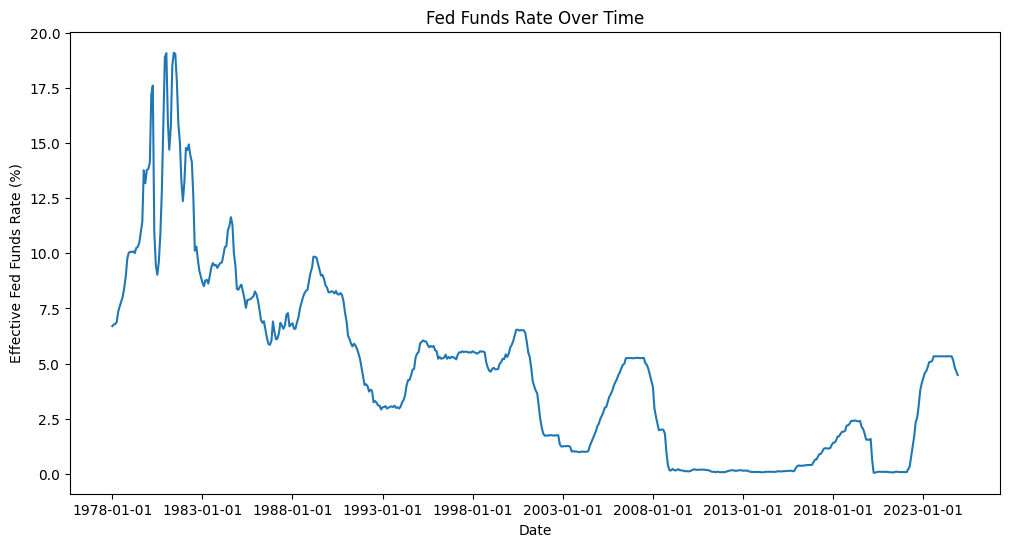

In [ ]:

## Fed Funds Line Plot
plt.figure(figsize=(12,6))
plt.plot(m_data['date'], m_data["FEDFUNDS"], linestyle='-')
plt.xticks(m_data['date'][::60])
plt.xlabel("Date")
plt.ylabel("Effective Fed Funds Rate (%)")
plt.title("Fed Funds Rate Over Time")
plt.show()




## 1. Train/Valid/Split

The train/valid/split is an 80/10/10 split sequentially on data starting from 01/01/1978 to 12/01/2024

In [7]:
train_size = int(len(m_data) * 0.8)
valid_size = int(len(m_data) * 0.1)
test_size = len(m_data) - train_size - valid_size

train, valid, test = m_data[:train_size], m_data[train_size:train_size+valid_size], m_data[train_size+valid_size:]
len(valid)

56

## 2. EDA

- Histogram of EFFR
- Lag Plot of EFFR
- ACF and PACF plot of EFFR

Right skewed distributions for extreme values seen in the earlier years of the time series. The highest frequency is at the lowest bin due to extended zero interest rate policy.

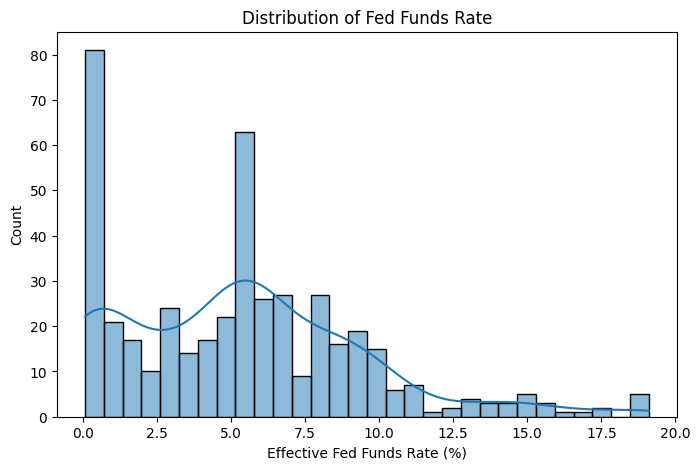

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(train["FEDFUNDS"], bins=30, kde=True)
plt.xlabel("Effective Fed Funds Rate (%)")
plt.title("Distribution of Fed Funds Rate")
plt.show()

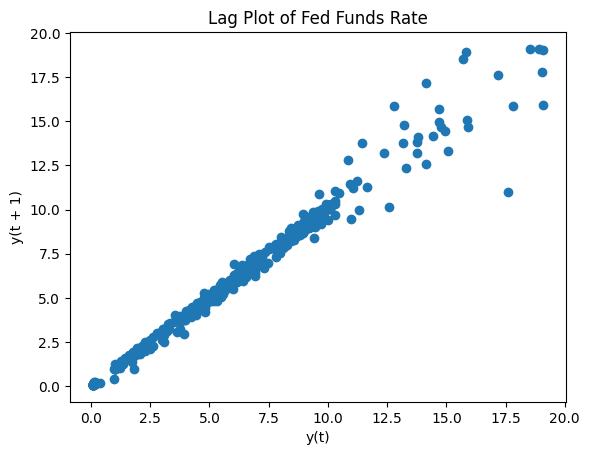

In [ ]:
pd.plotting.lag_plot(train["FEDFUNDS"])
plt.title("Lag Plot of Fed Funds Rate")
plt.show()

<Figure size 800x500 with 0 Axes>

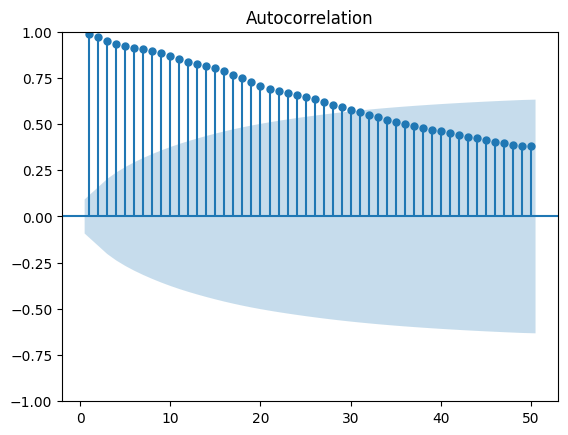

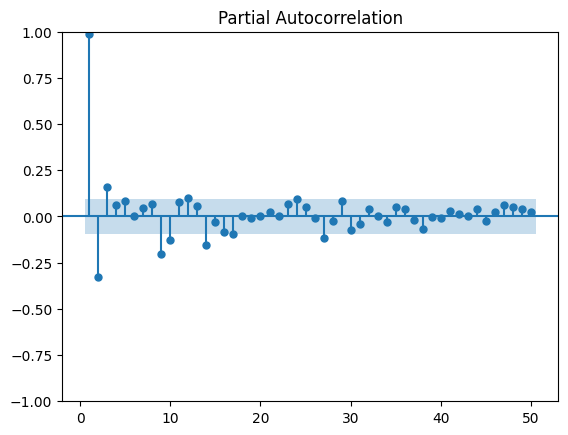

In [ ]:

## ACF and PACF Plot
plt.figure(figsize=(8, 5))

plot_acf(train["FEDFUNDS"].dropna(), lags=50, zero = False)
plt.show()
plot_pacf(train["FEDFUNDS"].dropna(), lags=50, zero = False)
plt.show()

## 3. RFE

To handle the 125+ Macro Economic Features on the FRED-MD file, we use RFE with Random Forest to select the top 30 features. RFE recursively removes the least "important" features.

In [9]:

X = train.drop(columns=["FEDFUNDS", "date"])
y = train["FEDFUNDS"]

rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X, y)

n_features_to_keep = 30

selector = RFE(estimator=rf, n_features_to_select=n_features_to_keep, step=1)
selector = selector.fit(X, y)



In [10]:
## Feature Importance

selected_features = X.columns[selector.support_]
print(f"Selected features: {selected_features.tolist()}")

feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
pd.set_option('display.max_rows', None)
print(feature_importance)
top_features = feature_importance.head(30)["Feature"].tolist()  # Keep top 30 features
top_df = m_data[top_features + ["FEDFUNDS"]]

## Data Frame for feature based models
selected_df = m_data[selected_features.tolist() + ["FEDFUNDS"]]

pd.set_option('display.max_rows', 15)
feature_importance.head(15)

Selected features: ['IPCONGD', 'CUMFNS', 'UEMPMEAN', 'UEMP27OV', 'CLAIMSx', 'USGOOD', 'CES1021000001', 'MANEMP', 'DMANEMP', 'NDMANEMP', 'USTRADE', 'M1SL', 'M2SL', 'M2REAL', 'TOTRESNS', 'CONSPI', 'S&P 500', 'S&P div yield', 'CP3Mx', 'TB3MS', 'TB6MS', 'GS1', 'COMPAPFFx', 'TB3SMFFM', 'TB6SMFFM', 'T5YFFM', 'T10YFFM', 'AAAFFM', 'BAAFFM', 'CES2000000008']
             Feature  Importance
75             CP3Mx    0.688498
76             TB3MS    0.201102
77             TB6MS    0.058694
78               GS1    0.030263
72           S&P 500    0.005945
85          TB6SMFFM    0.001196
89            AAAFFM    0.001118
90            BAAFFM    0.000722
88           T10YFFM    0.000665
87            T5YFFM    0.000663
66          TOTRESNS    0.000584
29          UEMP27OV    0.000563
64            M2REAL    0.000560
35            MANEMP    0.000477
117    CES2000000008    0.000467
67         NONBORRES    0.000459
36           DMANEMP    0.000436
37          NDMANEMP    0.000422
118    CES3000000008 

,Feature,Importance
75,CP3Mx,0.688498
76,TB3MS,0.201102
77,TB6MS,0.058694
78,GS1,0.030263
72,S&P 500,0.005945
85,TB6SMFFM,0.001196
89,AAAFFM,0.001118
90,BAAFFM,0.000722
88,T10YFFM,0.000665
87,T5YFFM,0.000663


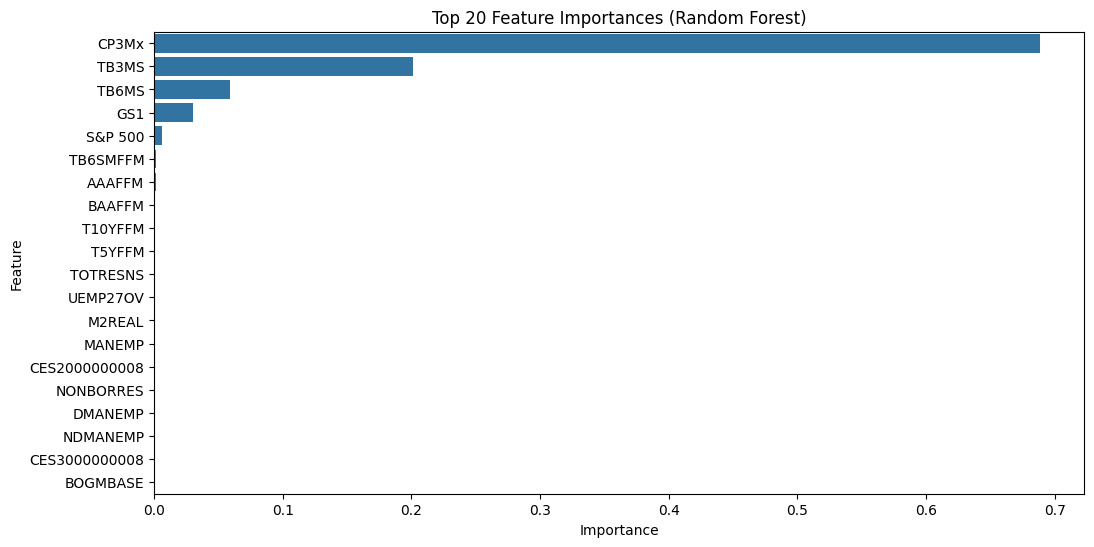

In [11]:
## Feature Importance Plot
top_20_features = feature_importance.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_features['Importance'], y=top_20_features['Feature'])
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Short term interest rate economic variables are the most important like commercial paper. However, we do see a variety of economic indicators choosen like M2 real money supply, unemployment, S&P 500 stock market index, unemployment rate.

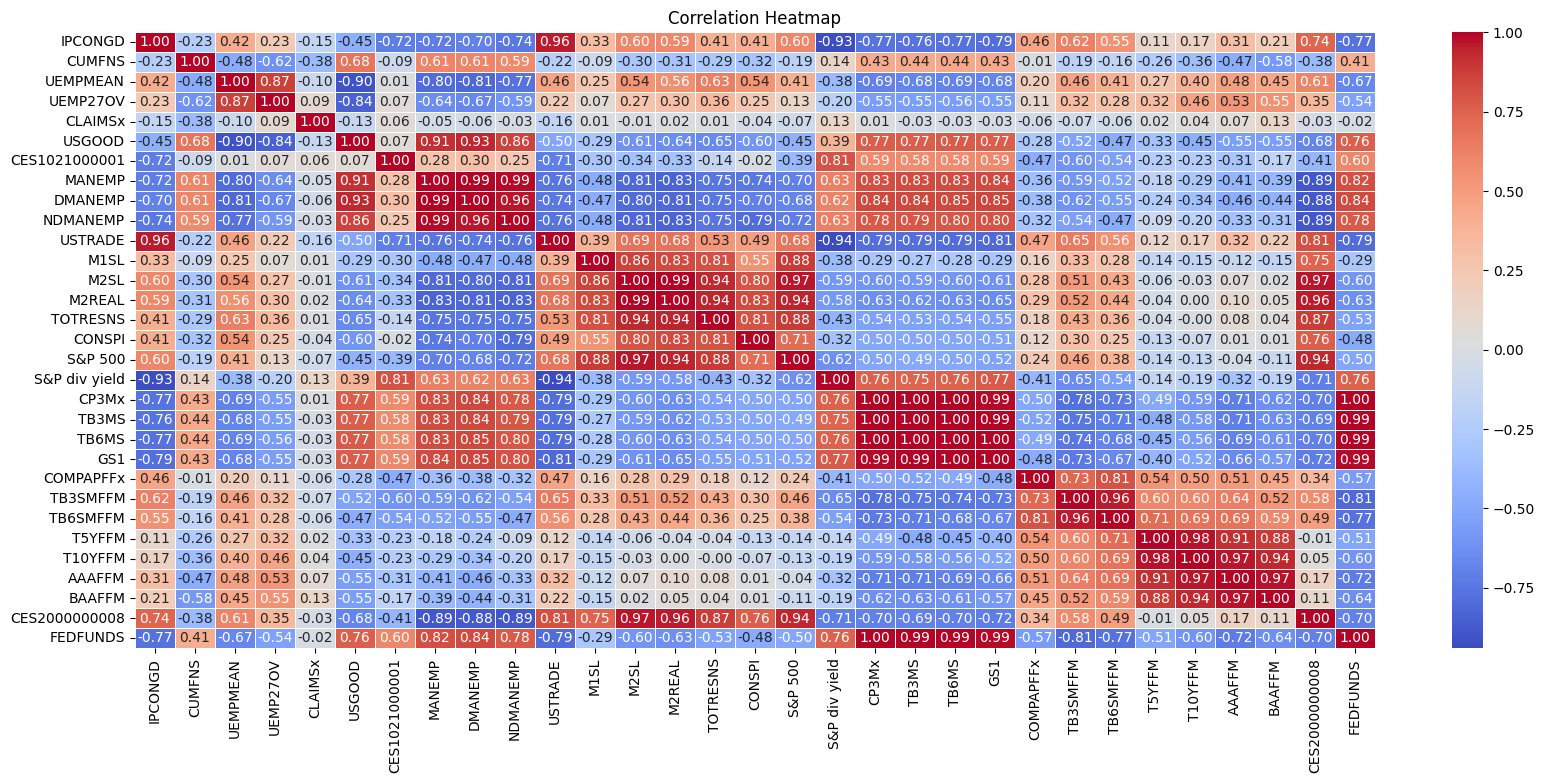

In [ ]:

## Corr plot for all features
plt.figure(figsize=(20, 8))
sns.heatmap(selected_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
#Multicolinearity fix depending on the model
selected_df2 = selected_df.drop(columns = ['TB3MS', 'TB6MS', 'GS1','BAAFFM', 'TB3SMFFM', 'T10YFFM', 'TOTRESNS','CUSR0000SAS', 'CPIMEDSL'])

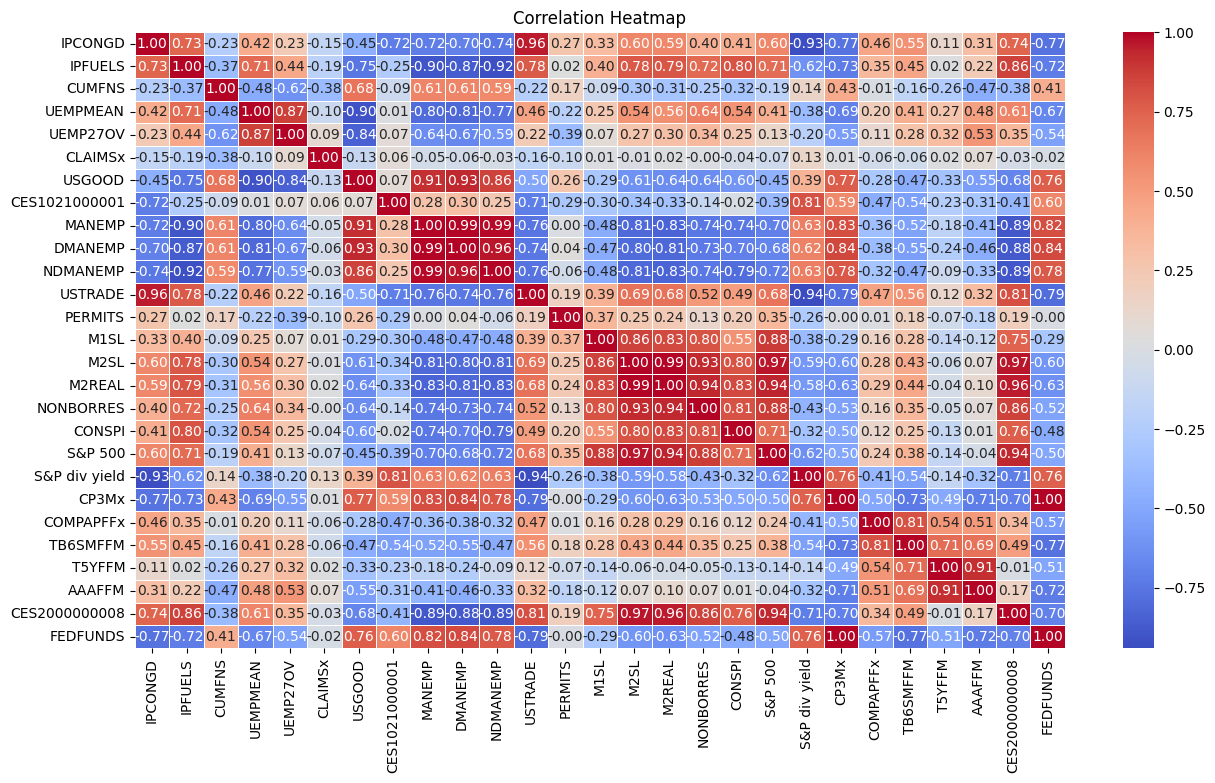

In [ ]:
## Selected features corr plot
plt.figure(figsize=(15, 8))
sns.heatmap(selected_df2.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

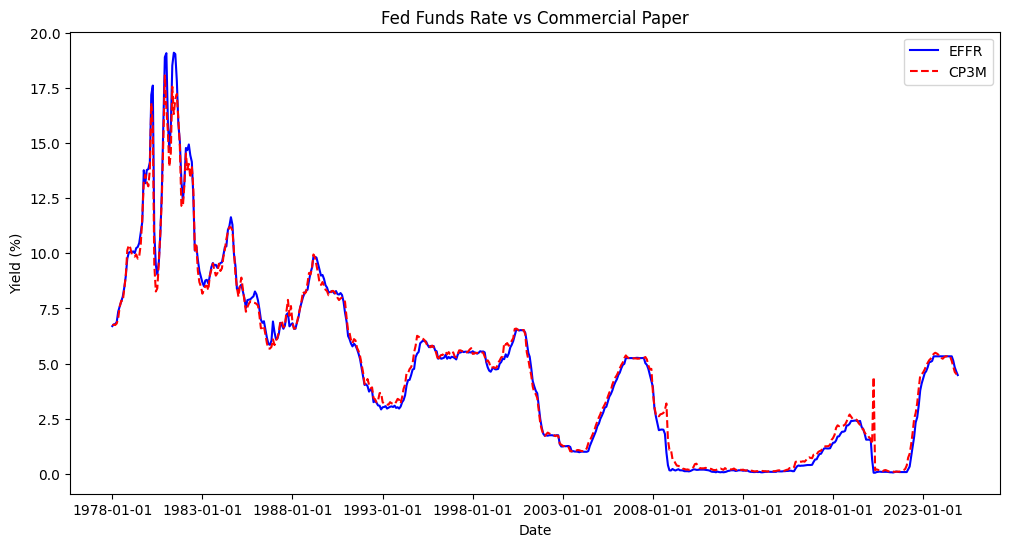

In [ ]:
## Commercial Paper vs EFFR
plt.figure(figsize=(12,6))
plt.plot(m_data['date'], m_data["FEDFUNDS"], color = 'b', linestyle='-', label="EFFR")
plt.plot(m_data['date'], m_data['CP3Mx'], color = 'r', linestyle = '--', label = "CP3M")
plt.xticks(m_data['date'][::60])
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.title("Fed Funds Rate vs Commercial Paper")
plt.legend()
plt.show()

## 4. EFFR Lags

Here, we incorporate 5 lags for the feature based machine learning models based on statistically signficant PACF lags.

In [12]:
uploaded = files.upload()
fedfunds_df = pd.read_csv("fed_funds_full.csv")
fedfunds_df['date'] = pd.to_datetime(fedfunds_df['observation_date'])
fedfunds_df = fedfunds_df.drop(columns = 'observation_date')
fedfunds_df = fedfunds_df[(fedfunds_df['date'] >= '1977-01-01') & (fedfunds_df['date'] <= '2024-12-01')]
fedfunds_df = fedfunds_df.reset_index(drop = True)
selected_df['date'] = m_data['date']



significant_lags = [1, 2, 3, 9, 10]  # Example based on PACF findings
fedfunds_lag1 = fedfunds_df[(fedfunds_df['date'] >= '1977-12-01') & (fedfunds_df['date'] <= '2024-11-01')]
fedfunds_lag1 = fedfunds_lag1.reset_index(drop = True)
fedfunds_lag2 = fedfunds_df[(fedfunds_df['date'] >= '1977-11-01') & (fedfunds_df['date'] <= '2024-10-01')]
fedfunds_lag2 = fedfunds_lag2.reset_index(drop = True)
fedfunds_lag3 = fedfunds_df[(fedfunds_df['date'] >= '1977-10-01') & (fedfunds_df['date'] <= '2024-09-01')]
fedfunds_lag3 = fedfunds_lag3.reset_index(drop = True)
#fedfunds_lag4 = fedfunds_df[(fedfunds_df['date'] >= '1977-09-01') & (fedfunds_df['date'] <= '2024-08-01')]
#fedfunds_lag4 = fedfunds_lag4.reset_index(drop = True)
fedfunds_lag9 = fedfunds_df[(fedfunds_df['date'] >= '1977-04-01') & (fedfunds_df['date'] <= '2024-03-01')]
fedfunds_lag9 = fedfunds_lag9.reset_index(drop = True)
fedfunds_lag10 = fedfunds_df[(fedfunds_df['date'] >= '1977-03-01') & (fedfunds_df['date'] <= '2024-02-01')]
fedfunds_lag10 = fedfunds_lag10.reset_index(drop = True)


selected_df['fedfunds_lag1'] = fedfunds_lag1['FEDFUNDS']
selected_df['fedfunds_lag2'] = fedfunds_lag2['FEDFUNDS']
selected_df['fedfunds_lag3'] = fedfunds_lag3['FEDFUNDS']
#selected_df['fedfunds_lag4'] = fedfunds_lag4['FEDFUNDS']
selected_df['fedfunds_lag9'] = fedfunds_lag9['FEDFUNDS']
selected_df['fedfunds_lag10'] = fedfunds_lag10['FEDFUNDS']


Saving fed_funds_full.csv to fed_funds_full.csv


<ipython-input-12-91fe332e3e32>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['date'] = m_data['date']
<ipython-input-12-91fe332e3e32>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['fedfunds_lag1'] = fedfunds_lag1['FEDFUNDS']
<ipython-input-12-91fe332e3e32>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [ ]:
## Export final feature based matrix
from google.colab import drive
drive.mount('/content/drive')
selected_df.to_csv('/content/drive/MyDrive/selected_df.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
selected_df

,IPCONGD,CUMFNS,UEMPMEAN,UEMP27OV,CLAIMSx,USGOOD,CES1021000001,MANEMP,DMANEMP,NDMANEMP,...,AAAFFM,BAAFFM,CES2000000008,FEDFUNDS,date,fedfunds_lag1,fedfunds_lag2,fedfunds_lag3,fedfunds_lag9,fedfunds_lag10
0,65.8820,82.0672,12.9,813,351000,23374,668.3,18593,11481,7112,...,1.71,2.47,7.77,6.70,1978-01-01,6.56,6.51,6.47,4.73,4.69
1,66.9695,82.1542,12.5,667,383250,23453,672.2,18639,11518,7121,...,1.69,2.42,7.82,6.78,1978-02-01,6.70,6.56,6.51,5.35,4.73
2,68.3259,83.3773,12.4,714,349000,23649,686.3,18699,11556,7143,...,1.68,2.43,7.90,6.79,1978-03-01,6.78,6.70,6.56,5.39,5.35
3,68.7741,84.4017,12.3,680,326000,24008,841.1,18772,11624,7148,...,1.67,2.43,7.94,6.89,1978-04-01,6.79,6.78,6.70,5.42,5.39
4,68.3908,84.5590,12.1,692,327000,24082,846.8,18848,11691,7157,...,1.33,2.13,8.03,7.36,1978-05-01,6.89,6.79,6.78,5.90,5.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,102.2118,76.9687,21.0,1545,231000,21835,596.7,12925,8100,4825,...,-0.46,0.27,35.81,5.33,2024-08-01,5.33,5.33,5.33,5.33,5.33
560,101.9696,76.6304,22.6,1614,224250,21850,598.2,12913,8096,4817,...,-0.45,0.29,36.00,5.13,2024-09-01,5.33,5.33,5.33,5.33,5.33
561,101.3127,75.9762,22.9,1608,237000,21797,597.8,12861,8047,4814,...,0.12,0.80,36.22,4.83,2024-10-01,5.13,5.33,5.33,5.33,5.33
562,101.7893,76.2166,23.6,1654,219000,21831,598.5,12886,8076,4810,...,0.49,1.13,36.21,4.64,2024-11-01,4.83,5.13,5.33,5.33,5.33


## 5. Taylor Rule

The most widely used formula to estimate the Fed Funds is the Taylor Rule

- Coefficients for both inflation and GDP gap are .5 and .5 throughout.
- We use core CPI, CBO, and forward fill quarterly GDP numbers.

In [13]:
from google.colab import files
uploaded = files.upload()

Saving CORESTICKY1.csv to CORESTICKY1.csv
Saving GDP.csv to GDP.csv


In [14]:
gdp_df = pd.read_csv("GDP.csv")
inf_df = pd.read_csv("CORESTICKY1.csv")
#gdp_inf = pd.merge(gdp_df, inf_df, on='observation_date')
print(inf_df.tail)
print(gdp_df.tail)
#print(gdp_inf.head)
#print(gdp_inf.shape)

<bound method NDFrame.tail of     observation_date  CORESTICKM159SFRBATL
0           1/1/1978              7.371988
1           2/1/1978              7.341035
2           3/1/1978              7.433603
3           4/1/1978              7.413807
4           5/1/1978              7.643491
..               ...                   ...
559         8/1/2024              4.103706
560         9/1/2024              4.010873
561        10/1/2024              3.965451
562        11/1/2024              3.876177
563        12/1/2024              3.746553

[564 rows x 2 columns]>
<bound method NDFrame.tail of     observation_date      GDPC1        GDPPOT
0           1/1/1978   6796.260   6872.575345
1           4/1/1978   7058.920   6931.925241
2           7/1/1978   7129.915   6992.745087
3          10/1/1978   7225.750   7054.840991
4           1/1/1979   7238.727   7119.064399
..               ...        ...           ...
184         1/1/2024  23053.545  22566.610000
185         4/1/2024  23223.906

In [15]:
last_valid2 = gdp_df['GDPC1'].dropna().iloc[-1]
second_last_valid2 = gdp_df['GDPC1'].dropna().iloc[-2]
gdp_df['GDPC1'].fillna(last_valid2 + (last_valid2 - second_last_valid2), inplace=True)

<ipython-input-15-0ad80d042323>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdp_df['GDPC1'].fillna(last_valid2 + (last_valid2 - second_last_valid2), inplace=True)


In [17]:
gdp_df['observation_date'] = pd.to_datetime(gdp_df['observation_date'])
gdp_df = gdp_df.set_index('observation_date')
gdp_df = gdp_df.resample('M').ffill() ## Forward Fill quarterly GDP
gdp_df = gdp_df.reset_index()

gdp_df = gdp_df[gdp_df['observation_date'] < '01-01-2025']

print(gdp_df)

    observation_date      GDPC1        GDPPOT
0         1978-01-31   6796.260   6872.575345
1         1978-02-28   6796.260   6872.575345
2         1978-03-31   6796.260   6872.575345
3         1978-04-30   7058.920   6931.925241
4         1978-05-31   7058.920   6931.925241
..               ...        ...           ...
559       2024-08-31  23400.294  22800.630000
560       2024-09-30  23400.294  22800.630000
561       2024-10-31  23530.909  22920.270000
562       2024-11-30  23530.909  22920.270000
563       2024-12-31  23530.909  22920.270000

[564 rows x 3 columns]


<ipython-input-17-fba97a293c42>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gdp_df = gdp_df.resample('M').ffill() ## Forward Fill quarterly GDP


In [18]:
## Taylor Rule

pi_star = 2
r_star = 2

#df_igdp["CPI"] = df_igdp['CORESTICKM159SFRBATL']
#df_igdp = df_igdp.drop(columns = ['CORESTICKM159SFRBATL'])

gdp_gap = (gdp_df["GDPC1"] - gdp_df["GDPPOT"])/gdp_df["GDPPOT"]

taylor_estimate = r_star + inf_df["CORESTICKM159SFRBATL"] + 0.5 * (inf_df["CORESTICKM159SFRBATL"] - pi_star) + 0.5 * gdp_gap

In [19]:
#TAYLORFEDFUNDS_df =m_data[m_data['date']<= '2024-10-01']
fedfunds = m_data['FEDFUNDS']


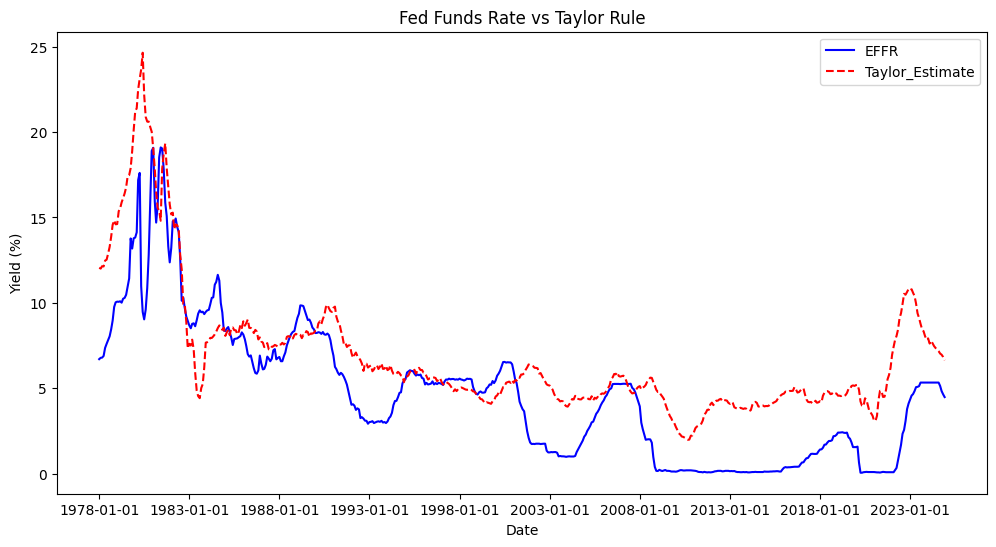

In [ ]:
## Taylor Rule vs Fed Funds
plt.figure(figsize=(12,6))
plt.plot(m_data['date'], m_data["FEDFUNDS"], color = 'b', linestyle='-', label = 'EFFR')
plt.plot(m_data['date'], taylor_estimate, color = 'r', linestyle = '--', label = 'Taylor_Estimate')
plt.xticks(m_data['date'][::60])
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.title("Fed Funds Rate vs Taylor Rule")
plt.legend()
plt.show()

Much larger deviations from the Taylor Rule seen lately although the general pattern remains similar.

In [20]:
RMSE_T = np.sqrt(np.mean((fedfunds - taylor_estimate)**2))
MAE_T = np.mean(np.abs((fedfunds - taylor_estimate)))
MPE_T = np.mean((fedfunds - taylor_estimate) / fedfunds)
MAPE_T = np.mean(np.abs((fedfunds - taylor_estimate) / fedfunds))
print('Taylor Rule RMSE:', RMSE_T)
print('Taylor Rule MAE:', MAE_T)
print('Taylor Rule MPE:', MPE_T)
print('Taylor Rule MAPE:', MAPE_T)


Taylor Rule RMSE: 3.339050964754848
Taylor Rule MAE: 2.654028495239327
Taylor Rule MPE: -7.902463780784951
Taylor Rule MAPE: 7.954608937823237


## 6. Tree Based Models:

Now, we optimize a Random Forest and Light GBM model by using Grid Searches for a variety of parameters.

In [21]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import ParameterGrid

In [22]:
train_tree, valid_tree, test_tree = selected_df[:train_size], selected_df[train_size:train_size+valid_size], selected_df[train_size+valid_size:]

X_train = train_tree.drop(columns = ['FEDFUNDS', 'date'])
y_train = train_tree[['date', 'FEDFUNDS']]
X_valid = valid_tree.drop(columns = ['FEDFUNDS', 'date'])
y_valid = valid_tree[['date','FEDFUNDS']]
X_test = test_tree.drop(columns = ['FEDFUNDS', 'date'])
y_test = test_tree[['date', 'FEDFUNDS']]

In [23]:
X_test

,IPCONGD,CUMFNS,UEMPMEAN,UEMP27OV,CLAIMSx,USGOOD,CES1021000001,MANEMP,DMANEMP,NDMANEMP,...,T5YFFM,T10YFFM,AAAFFM,BAAFFM,CES2000000008,fedfunds_lag1,fedfunds_lag2,fedfunds_lag3,fedfunds_lag9,fedfunds_lag10
507,84.2552,62.3158,7.2,910,4663250,18565,572.0,11419,7067,4352,...,0.34,0.61,2.38,4.08,28.75,0.65,1.58,1.55,2.40,2.38
508,87.6851,65.1109,10.5,1147,2173400,19256,548.0,11652,7204,4448,...,0.29,0.62,2.45,3.90,28.96,0.05,0.65,1.58,2.13,2.40
509,95.6070,70.2397,14.4,1355,1490250,19716,532.6,11982,7460,4522,...,0.26,0.65,2.36,3.56,29.22,0.05,0.05,0.65,2.04,2.13
510,99.8693,72.7878,17.0,1544,1383500,19780,523.2,12019,7494,4525,...,0.19,0.53,2.05,3.22,29.29,0.08,0.05,0.05,1.83,2.04
511,100.6604,73.9997,19.9,1632,922400,19832,515.6,12047,7487,4560,...,0.18,0.56,2.16,3.18,29.39,0.09,0.08,0.05,1.55,1.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,102.2118,76.9687,21.0,1545,231000,21835,596.7,12925,8100,4825,...,-1.62,-1.46,-0.46,0.27,35.81,5.33,5.33,5.33,5.33,5.33
560,101.9696,76.6304,22.6,1614,224250,21850,598.2,12913,8096,4817,...,-1.63,-1.41,-0.45,0.29,36.00,5.33,5.33,5.33,5.33,5.33
561,101.3127,75.9762,22.9,1608,237000,21797,597.8,12861,8047,4814,...,-0.92,-0.73,0.12,0.80,36.22,5.13,5.33,5.33,5.33,5.33
562,101.7893,76.2166,23.6,1654,219000,21831,598.5,12886,8076,4810,...,-0.42,-0.29,0.49,1.13,36.21,4.83,5.13,5.33,5.33,5.33


In [24]:
param_grid = {'max_features': ['sqrt', 'log2',0.5, 0.8]} ## Optimizing the number of features to build each tree
rf2 = RandomForestRegressor(random_state = 30)
grids_rf = GridSearchCV(estimator=rf2, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
rfg_results = grids_rf.fit(X_train, y_train['FEDFUNDS'])

feat = grids_rf.best_params_['max_features']
print("Best Parameters:", grids_rf.best_params_)
print("Best Cross Validated MSE:", grids_rf.best_score_)

rf3 = RandomForestRegressor(max_features = feat, random_state = 30)
rf_results = rf3.fit(X_train, y_train['FEDFUNDS'])


Best Parameters: {'max_features': 0.8}
Best Cross Validated MSE: -3.019842912618076


               importance 
CP3Mx             0.409519
fedfunds_lag1     0.244833
TB3MS             0.187865
TB6MS             0.110280
GS1               0.024190
fedfunds_lag2     0.009555
AAAFFM            0.001422
TB6SMFFM          0.001140
BAAFFM            0.001094
TOTRESNS          0.001092


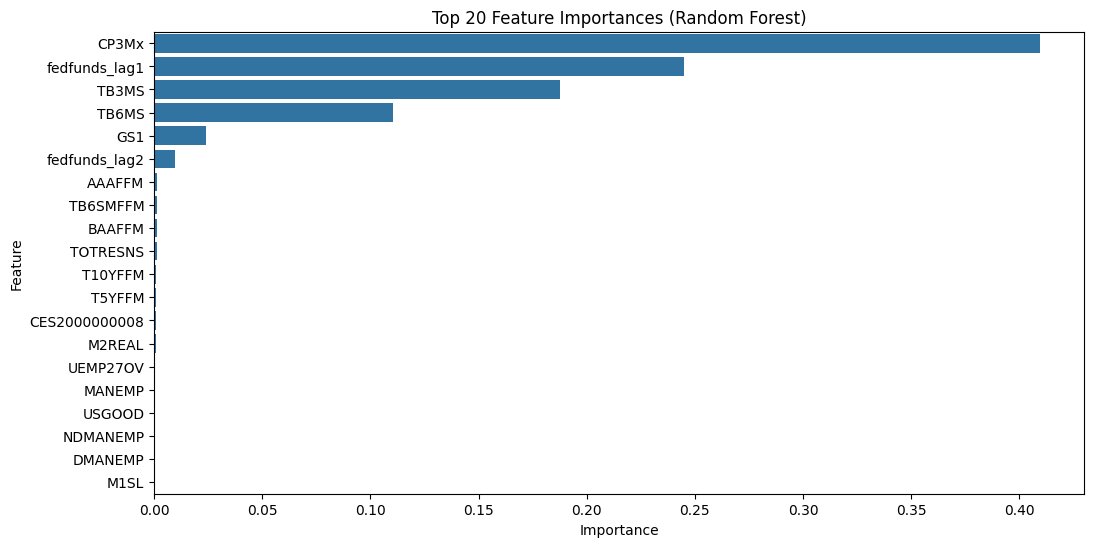

In [25]:
## Feature Importance rf
fn = list(X_train.columns)
feature_importance = pd.DataFrame(
    {'importance ':rf_results.feature_importances_},
    index=fn)
print(feature_importance.sort_values(by='importance ', ascending=False).head(10))


top_20_features = feature_importance.sort_values(by='importance ', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_features['importance '], y=top_20_features.index)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [26]:
def predict_with_intervals(model, X, n_trees=100, quantiles=[0.025, 0.975], model_type = "rf"):

  '''
  inputs:
  model = the fitted model
  X = data frame
  n_trees = the amount of trees
  quantiles = defines the quantiles of the prediction intervals
  model_type = "rf" or "lgb"

  output:
  preds = the predictions
  lower_bound = the lower bound of the prediction intervals
  upper_bound = the upper bound of the prediction intervals
  '''


  if model_type == "rf":
      preds = []
      for _ in range(n_trees):
          sampled_indices = np.random.choice(model.n_estimators, size=model.n_estimators, replace=True)
          sampled_indices = sampled_indices.astype(int).tolist()
          sampled_model = [model.estimators_[i] for i in sampled_indices]

          pred = np.mean([tree.predict(X) for tree in sampled_model], axis=0) ## Bagging
          preds.append(pred)

  elif model_type == "lgb":
      max_iter = model.best_iteration or model.num_trees()
      preds = []
      for _ in range(n_trees):
          max_iter = model.best_iteration or model.num_trees()
          sampled_iters = np.random.choice(max_iter, size=max_iter, replace=True) ## Boosting
          ## GAUSSIAN NOISE
          X_noisy = X + np.random.normal(0, 0.05, X.shape)

          pred = model.predict(X_noisy, num_iteration=model.best_iteration or model.num_trees())

          preds.append(pred)


    # Calculate prediction intervals
  preds = np.array(preds)
  lower_bound = np.quantile(preds, quantiles[0], axis=0)
  upper_bound = np.quantile(preds, quantiles[1], axis=0)

  return np.mean(preds, axis=0), lower_bound, upper_bound

In [27]:
rfpredval, lower_bound, upper_bound = predict_with_intervals(rf3, X_valid)
rfpredtest, lower_bound_test, upper_bound_test = predict_with_intervals(rf3, X_test)




Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dis

In [28]:
rf_valid_RMSE = np.sqrt(np.mean((y_valid['FEDFUNDS'] - rfpredval)**2))
rf_valid_MAE = np.mean(np.abs((y_valid['FEDFUNDS']- rfpredval)))
rf_valid_MPE = np.mean((y_valid['FEDFUNDS'] - rfpredval) / y_valid['FEDFUNDS']) * 100
rf_valid_MAPE = np.mean(np.abs((y_valid['FEDFUNDS']- rfpredval) / y_valid['FEDFUNDS'])) * 100
print('RF VALID RMSE:', rf_valid_RMSE)
print('RF VALID MAE:', rf_valid_MAE)
print('RF VALID MPE:', rf_valid_MPE)
print('RF VALID MAPE:', rf_valid_MAPE)

RF VALID RMSE: 0.5481222643960892
RF VALID MAE: 0.47392016071428567
RF VALID MPE: 34.44212045243631
RF VALID MAPE: 40.041882357198226


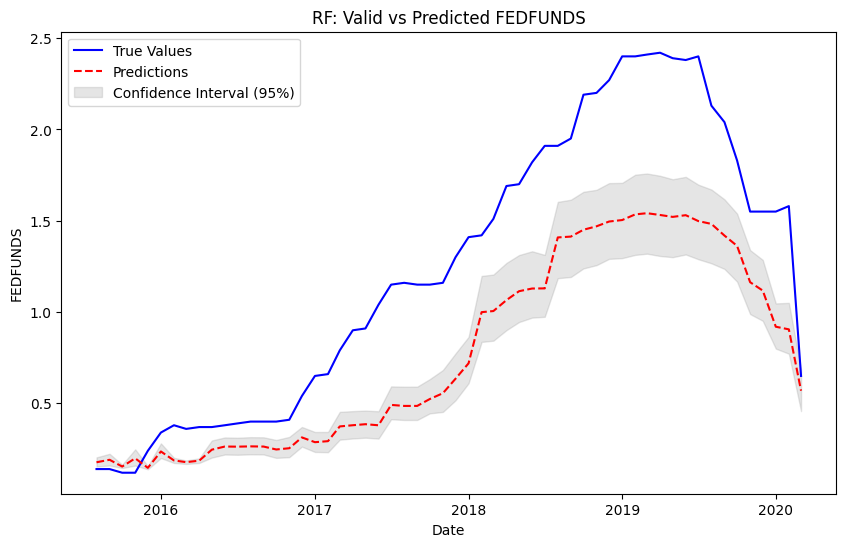

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(y_valid['date'], y_valid['FEDFUNDS'], label="True Values", color='blue')
plt.plot(y_valid['date'], rfpredval, label="Predictions", color='red', linestyle='--')
plt.fill_between(y_valid['date'], lower_bound, upper_bound, color='gray', alpha=0.2, label="Confidence Interval (95%)")
plt.title('RF: Valid vs Predicted FEDFUNDS')
plt.xlabel('Date')
plt.ylabel('FEDFUNDS')
plt.legend()
plt.show()
#

## 6b : GPR for forecasting future time periods

After final evaluation in the Ensemble and Forecast Notebook we saw the Random Forest had the best RMSE and MAE on the test data. We use a GPR to extrapolate feature variables to make forecast on future periods.

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import RationalQuadratic as RQ

In [31]:

'''
input:
X_test: Test data
steps: number of steps to forecast

output:
future_forecasts_df: Dataframe of future forecasts
'''
def gpr(X_test, steps):
  X_time = np.arange(len(X_test)).reshape(-1, 1)


  future_steps = steps
  X_future = np.arange(len(X_test), len(X_test) + future_steps).reshape(-1, 1)

  future_forecasts = {}


  for feature in X_test.columns:
      y_train = X_test[feature].values

      kernel = RQ(length_scale=1.0, alpha=1.0) ## Rational Quadratic

      gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
      gp.fit(X_time, y_train)

      y_pred, sigma = gp.predict(X_future, return_std=True)

      future_forecasts[feature] = y_pred

  future_forecasts_df = pd.DataFrame(future_forecasts, columns = X_test.columns)
  return future_forecasts_df



In [32]:
gpr_60 = gpr(X_test, 62)
gpr_12 = gpr(X_test, 14)
gpr_1 = gpr(X_test, 4)

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/lo

In [ ]:
gpr_1.iloc[2]

,2
IPCONGD,101.689133
CUMFNS,76.670331
UEMPMEAN,22.724785
UEMP27OV,1535.998570
CLAIMSx,472164.509145
...,...
fedfunds_lag1,4.359924
fedfunds_lag2,4.364495
fedfunds_lag3,4.428320
fedfunds_lag9,4.860242


In [ ]:
rffuture60 = rf3.predict(gpr_60[2:])
future_dates60 = pd.date_range(start='2025-02-01', periods=60 + 1, freq='M')[1:]
rffuture60 = pd.DataFrame({'date': future_dates60, 'rf_forecast': rffuture60} )
rffuture12 = rf3.predict(gpr_12[2:])
future_dates12 = pd.date_range(start='2025-02-01', periods=12 + 1, freq='M')[1:]
rffuture12 = pd.DataFrame({'date': future_dates12, 'rf_forecast': rffuture12} )







         date  rf_forecast
0  2025-03-31       4.0904
1  2025-04-30       4.0722
2  2025-05-31       3.9727
3  2025-06-30       3.9448
4  2025-07-31       3.9133
..        ...          ...
55 2029-10-31       2.8681
56 2029-11-30       2.8681
57 2029-12-31       2.8684
58 2030-01-31       2.8684
59 2030-02-28       2.8684

[60 rows x 2 columns]
         date  rf_forecast
0  2025-03-31       4.0904
1  2025-04-30       4.0722
2  2025-05-31       3.9727
3  2025-06-30       3.9448
4  2025-07-31       3.9133
5  2025-08-31       3.7212
6  2025-09-30       3.6087
7  2025-10-31       3.5729
8  2025-11-30       3.5510
9  2025-12-31       3.5417
10 2026-01-31       3.5334
11 2026-02-28       3.4314


<ipython-input-52-4633617ae306>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates60 = pd.date_range(start='2025-02-01', periods=60 + 1, freq='M')[1:]
<ipython-input-52-4633617ae306>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates12 = pd.date_range(start='2025-02-01', periods=12 + 1, freq='M')[1:]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

rffuture60.to_csv('/content/drive/MyDrive/rffuture60.csv', index=False)
rffuture12.to_csv('/content/drive/MyDrive/rffuture12.csv', index=False)


Mounted at /content/drive


In [34]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from itertools import product
from sklearn.metrics import mean_squared_error

param_grid = {
    'num_leaves': [31, 50, 100], ## number of leaves before node split
    'learning_rate': [0.05, 0.1, 0.2], ## Learning Rate
    'n_estimators': [100, 200], ## Number of trees
    'boosting_type': ['gbdt', 'dart'], ## Boosting type
}

train_data = lgb.Dataset(X_train, label=y_train['FEDFUNDS'])
val_data_lgb = lgb.Dataset(X_valid, label=y_valid['FEDFUNDS'], reference=train_data)

best_score = float('inf')
best_params = {}

results = []

def log_callback(env):
    if env.iteration % 50 == 0:
        train_rmse.append(env.evaluation_result_list[0][2])
        val_rmse.append(env.evaluation_result_list[1][2])

# Loop through every combination of hyperparameters
for num_leaves, learning_rate, n_estimators, boosting_type in product(*param_grid.values()):
    train_rmse = []
    val_rmse = []

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        'boosting_type': boosting_type,
        'random_state': 40
    }

    print(f"Training with: num_leaves={num_leaves}, learning_rate={learning_rate}, n_estimators={n_estimators}, boosting_type={boosting_type}")

    lgbm_model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=[train_data, val_data_lgb],
        valid_names=['train', 'valid'],
        num_boost_round=1000,
        callbacks=[lgb.log_evaluation(50), log_callback]
    )

    final_rmse = val_rmse[-1]
    results.append({
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        'boosting_type': boosting_type,
        'val_rmse': final_rmse
    })

    if final_rmse < best_score:
        best_score = final_rmse
        best_params = params

results_df = pd.DataFrame(results).sort_values(by='val_rmse')
print("Best Parameters:")
print(best_params)
print("Best RMSE:", best_score)


Training with: num_leaves=31, learning_rate=0.05, n_estimators=100, boosting_type=gbdt
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5034
[LightGBM] [Info] Number of data points in the train set: 451, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 5.333792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5034
[LightGBM] [Info] Number of data points in the train set: 451, number of used features: 35
[LightGBM] [Info] Start training from score 5.333792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

<ipython-input-35-888646ccb058>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


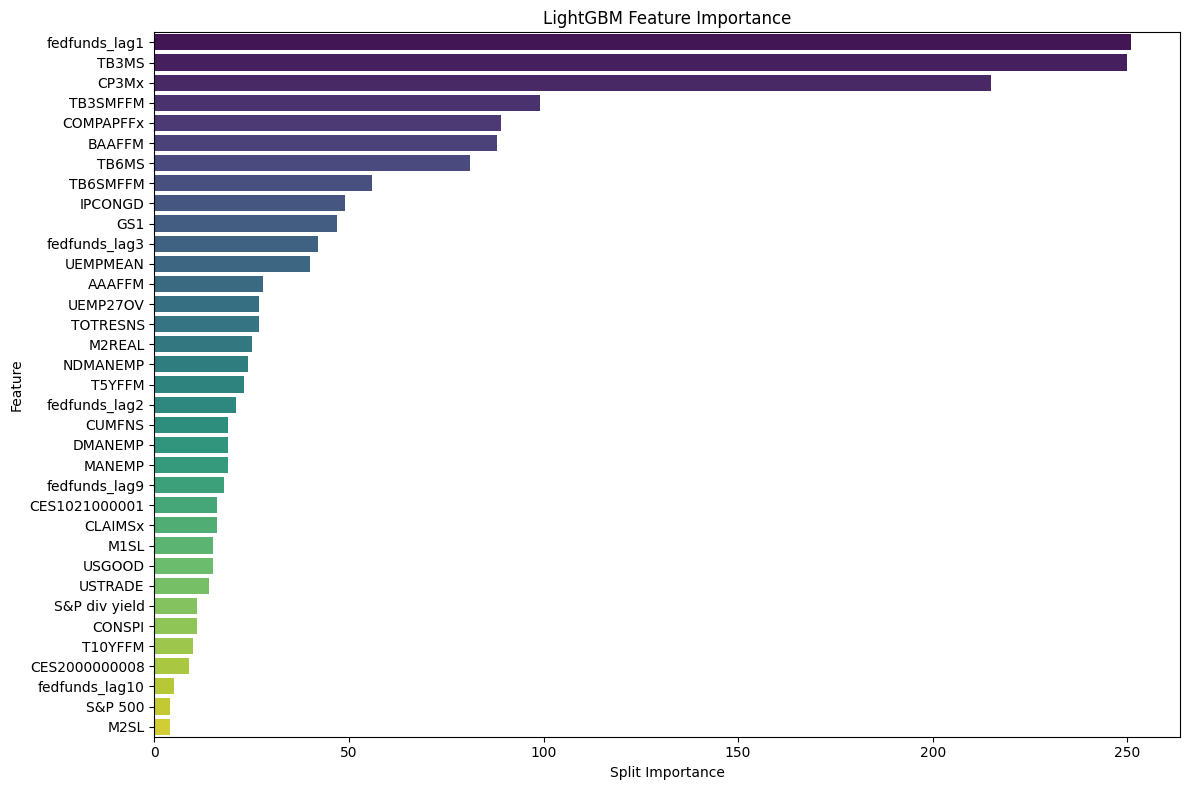

In [35]:
## Retrain model with best params

best_lgbm_model = lgb.train(
    best_params,
    train_set=train_data,
    valid_sets=[train_data],
    num_boost_round=1000,
    callbacks=[lgb.log_evaluation(50)]
)


importance = best_lgbm_model.feature_importance(importance_type='split')
features = X_train.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('LightGBM Feature Importance')
plt.xlabel('Split Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [36]:
lgbmpredval, lower_bound2, upper_bound2 = predict_with_intervals(best_lgbm_model, X_valid, model_type = "lgb")
lgbmpredtest, lower_bound_test2, upper_bound_test2 = predict_with_intervals(best_lgbm_model, X_test, model_type = "lgb")

In [37]:


lgbm_valid_RMSE = np.sqrt(np.mean((y_valid['FEDFUNDS'] - lgbmpredval)**2))
lgbm_valid_MAE = np.mean(np.abs((y_valid['FEDFUNDS']- lgbmpredval)))
lgbm_valid_MPE = np.mean((y_valid['FEDFUNDS'] - lgbmpredval) / y_valid['FEDFUNDS']) * 100
lgbm_valid_MAPE = np.mean(np.abs((y_valid['FEDFUNDS']- lgbmpredval) / y_valid['FEDFUNDS'])) * 100

print('LGBM VALID RMSE:', lgbm_valid_RMSE)
print('LGBM VALID MAE:', lgbm_valid_MAE)
print('LGBM VALID MPE:', lgbm_valid_MPE)
print('LGBM VALID MAPE:', lgbm_valid_MAPE)

LGBM VALID RMSE: 0.5258230998790296
LGBM VALID MAE: 0.45633255526359867
LGBM VALID MPE: 7.770682600245002
LGBM VALID MAPE: 45.43887073243933


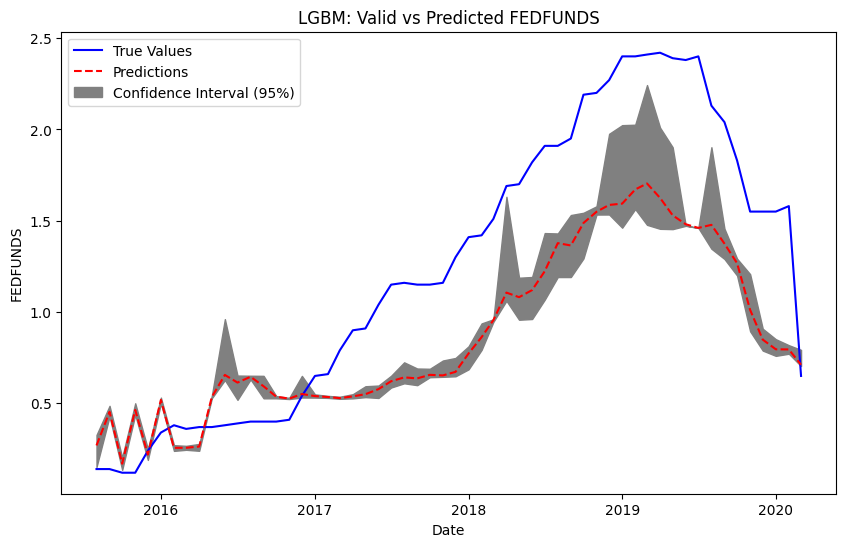

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(y_valid['date'], y_valid['FEDFUNDS'], label="True Values", color='blue')
plt.plot(y_valid['date'], lgbmpredval, label="Predictions", color='red', linestyle='--')
plt.fill_between(y_valid['date'], lower_bound2, upper_bound2, color='gray', alpha=1, label="Confidence Interval (95%)")
plt.title('LGBM: Valid vs Predicted FEDFUNDS')
plt.xlabel('Date')
plt.ylabel('FEDFUNDS')
plt.legend()
plt.show()

## 7. Export and Calculate Test Predictions and Metrics

In [39]:
## Trim Taylor

taylor_estimate_valid = taylor_estimate[451:507].reset_index(drop = True)
taylor_estimate_test = taylor_estimate[507:]


stat_preds_val2 = pd.DataFrame({ 'taylor_estimate':  np.array(taylor_estimate_valid), 'lightgbm': lgbmpredval, 'random_forest': rfpredval} )
stat_preds_test2 = pd.DataFrame({'taylor_estimate':  np.array(taylor_estimate_test), 'lightgbm': lgbmpredtest, 'random_forest': rfpredtest} )


from google.colab import drive
drive.mount('/content/drive')
stat_preds_val2.to_csv('/content/drive/MyDrive/stat_preds_val.csv', index=False)
stat_preds_test2.to_csv('/content/drive/MyDrive/stat_preds_test.csv', index=False)

Mounted at /content/drive


In [40]:
taylor_valid_RMSE = np.sqrt(np.mean((y_valid['FEDFUNDS'] - np.array(taylor_estimate_valid))**2))
taylor_valid_MAE = np.mean(np.abs((y_valid['FEDFUNDS']- np.array(taylor_estimate_valid))))
taylor_valid_MPE = np.mean((y_valid['FEDFUNDS'] - np.array(taylor_estimate_valid)) / y_valid['FEDFUNDS']) * 100
taylor_valid_MAPE = np.mean(np.abs((y_valid['FEDFUNDS']- np.array(taylor_estimate_valid)) / y_valid['FEDFUNDS'])) * 100
print('Taylor VALID RMSE:', taylor_valid_RMSE)
print('Taylor VALID MAE:', taylor_valid_MAE)
print('Taylor VALID MPE:', taylor_valid_MPE)
print('Taylor VALID MAPE:', taylor_valid_MAPE)


taylor_test_RMSE = np.sqrt(np.mean((y_test['FEDFUNDS'] - np.array(taylor_estimate_test))**2))
taylor_test_MAE = np.mean(np.abs((y_test['FEDFUNDS']- np.array(taylor_estimate_test))))
taylor_test_MPE = np.mean((y_test['FEDFUNDS'] - np.array(taylor_estimate_test)) / y_test['FEDFUNDS']) * 100
taylor_test_MAPE = np.mean(np.abs((y_test['FEDFUNDS']- np.array(taylor_estimate_test)) / y_test['FEDFUNDS'])) * 100


Taylor VALID RMSE: 3.5193823134965356
Taylor VALID MAE: 3.423662720994124
Taylor VALID MPE: -674.4104757492556
Taylor VALID MAPE: 674.4104757492556


In [41]:
valid_performance_2 = pd.DataFrame({'RMSE': [ taylor_valid_RMSE, lgbm_valid_RMSE, rf_valid_RMSE],
                                  'MAE': [ taylor_valid_MAE, lgbm_valid_MAE, rf_valid_MAE],
                                  'MPE': [ taylor_valid_MPE, lgbm_valid_MPE, rf_valid_MPE],
                                  'MAPE' : [ taylor_valid_MAPE, lgbm_valid_MAPE, rf_valid_MAPE ]})

valid_performance_2.index = [ 'Taylor', 'LightGBM', 'Random Forest']
print(valid_performance_2)

drive.mount('/content/drive')
valid_performance_2.to_csv('/content/drive/MyDrive/valid_performance.csv', index=False)



                   RMSE       MAE         MPE        MAPE
Taylor         3.519382  3.423663 -674.410476  674.410476
LightGBM       0.525823  0.456333    7.770683   45.438871
Random Forest  0.548122  0.473920   34.442120   40.041882
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
## Function for test performance metrics
def test_performance_metrics(y_true, y_pred):
  '''
  input:
  y_true: true values
  y_pred: predicted values

  output:
  rmse: root mean squared error
  mae: mean absolute error
  mpe: mean percentage error
  mape: mean absolute percentage error
  '''
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mae = np.mean(np.abs(y_true - y_pred))
    mpe = np.mean((y_true - y_pred) / y_true) * 100
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mpe, mape

In [44]:

lgbm_test_RMSE, lgbm_test_MAE, lgbm_test_MPE, lgbm_test_MAPE = test_performance_metrics(y_test['FEDFUNDS'], lgbmpredtest)
rf_test_RMSE, rf_test_MAE, rf_test_MPE, rf_test_MAPE = test_performance_metrics(y_test['FEDFUNDS'], rfpredtest)

In [46]:
test_performance_2 = pd.DataFrame({'RMSE': [ taylor_test_RMSE,  lgbm_test_RMSE, rf_test_RMSE],
                                  'MAE': [ taylor_test_MAE, lgbm_test_MAE, rf_test_MAE],
                                  'MPE': [ taylor_test_MPE, lgbm_test_MPE, rf_test_MPE],
                                  'MAPE' : [ taylor_test_MAPE, lgbm_test_MAPE, rf_test_MAPE ]})

test_performance_2.index = [ 'Taylor', 'LightGBM', 'Random Forest']


drive.mount('/content/drive')
test_performance_2.to_csv('/content/drive/MyDrive/test_performance.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
conf_int_val = pd.DataFrame({'rf_lower' : lower_bound, 'rf_upper' : upper_bound, 'lgb_lower' : lower_bound2, 'lgb_upper' : upper_bound2})
conf_int_test = pd.DataFrame({'rf_lower' : lower_bound_test, 'rf_upper' : upper_bound_test, 'lgb_lower' : lower_bound_test2, 'lgb_upper' : upper_bound_test2})
drive.mount('/content/drive')
conf_int_val.to_csv('/content/drive/MyDrive/conf_int_val.csv', index=False)
conf_int_test.to_csv('/content/drive/MyDrive/conf_int_test.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
